## Imports and inital setup

In [1]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
NUM_EPOCHS = 10

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx_binary"
BALANCE_LABEL="dx"
IMAGE_SIZE = (224, 224)

### Loading (augmented) metadata as test, train, validation from files

In [4]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
332,HAM_0006350,ISIC_0031130.jpg,bkl,histo,50.0,female,chest,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0031130.jpg
4841,HAM_0004568,aug_E1PIOZISIC_0028795.jpg,akiec,histo,50.0,male,upper extremity,rosendahl,skin_cancer,./../data/jpgs/aug_E1PIOZISIC_0028795.jpg
4014,HAM_0002829,ISIC_0029134.jpg,nv,follow_up,30.0,male,trunk,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0029134.jpg
3337,HAM_0006862,ISIC_0025296.jpg,nv,follow_up,50.0,female,trunk,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0025296.jpg
9251,HAM_0004455,aug_x4lJysISIC_0030882.jpg,vasc,histo,20.0,male,trunk,vidir_modern,not_skin_cancer,./../data/jpgs/aug_x4lJysISIC_0030882.jpg
8608,HAM_0004756,aug_MnXZmAISIC_0030442.jpg,df,histo,55.0,male,lower extremity,vienna_dias,not_skin_cancer,./../data/jpgs/aug_MnXZmAISIC_0030442.jpg
5962,HAM_0000832,aug_0gputTISIC_0028763.jpg,akiec,histo,85.0,male,upper extremity,rosendahl,skin_cancer,./../data/jpgs/aug_0gputTISIC_0028763.jpg
5407,HAM_0000954,aug_WUyxNzISIC_0026100.jpg,akiec,histo,70.0,male,lower extremity,rosendahl,skin_cancer,./../data/jpgs/aug_WUyxNzISIC_0026100.jpg
7248,HAM_0005482,aug_gj6PEvISIC_0029546.jpg,bcc,histo,45.0,female,back,rosendahl,skin_cancer,./../data/jpgs/aug_gj6PEvISIC_0029546.jpg
6172,HAM_0007588,ISIC_0031526.jpg,bcc,histo,55.0,female,back,rosendahl,skin_cancer,./../data/jpgs/ISIC_0031526.jpg


## Setting up the image data generator for training and validation

In [6]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0 #see above
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 2003 validated image filenames belonging to 2 classes.
Found 10506 validated image filenames belonging to 2 classes.


# Adding an neural network model to test the data

## Simple Model Architecture

Source: https://www.tensorflow.org/tutorials/images/cnn (with minor changes)

In [8]:
# Define super basic neural network architecture
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

    # Convolutional block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # Flattening the output of the convolutional layers
    tf.keras.layers.Flatten(),

    # Dense (fully connected) layers
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)            0

## Model Training

In [10]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=None,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=None,                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/10
121/329 [==========>...................] - ETA: 2:12 - loss: 0.7524 - accuracy: 0.5478

## Plotting accuracy and loss of train and validation set

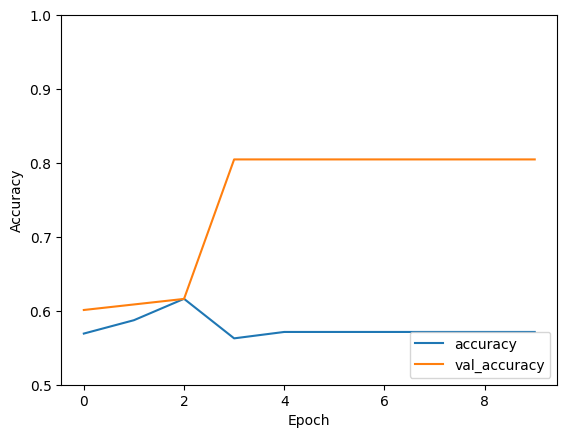

In [100]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


# load test images from test_df
test_images = []
test_labels = []

for i in range(test_df.shape[0]):
    image_path = test_df.iloc[i]['image_path']
    img = load_and_preprocess_image(image_path)
    # convert img to np array
    img = np.array(img)
    test_images.append(img)
    test_labels.append(test_df.iloc[i][TARGET_LABEL])


## Evaluating the model on the test set

In [101]:
from keras.utils import to_categorical

# using label encoder to get the labels

le = LabelEncoder()
test_labels = le.fit_transform(test_df[TARGET_LABEL])

# converting to one hot format / categorial
test_labels = to_categorical(test_labels)

# reshaping the test images
#test_images = np.array(test_images).reshape(-1, 128, 128, 3)
test_images = np.array(test_images).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

63/63 - 8s - loss: 0.7027 - accuracy: 0.8043 - 8s/epoch - 123ms/step


## Saving the model

In [102]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.keras"
model.save(model_path)